# ДЗ №7
Краевая задача для ОДУ второго порядка

Ниже решение данного уравнения:
$\frac{x - 2}{x + 2}u'' + xu' + (1 - sin(x))u = x^2$

с краевыми условиями:
$u(-1) = u(1) = 0$

In [1]:
from typing import Callable, List, Tuple, Iterable

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
class ApproximationProcess:
    def __init__(self):
        self.apprs = []

    def append(self, points: np.ndarray):
        if len(self.apprs) != 0 and self.apprs[-1].shape[0] != points.shape[0]:
            raise ValueError('Wrong dimensions')
        self.apprs.append(points)

    def plot(self, ):
        if len(self.apprs) == 0:
            raise ValueError('No approximations made')
        dim = self.apprs[0].shape[0]
        if dim == 2:
            colors = sns.color_palette("rocket_r", n_colors=len(self.apprs))
            for appr, color in zip(self.apprs, colors):
                sns.lineplot(x=appr[0, :], y=appr[1, :], color=color)
            plt.show()
        else:
            raise ValueError(f'Doesn\'t support {dim}-d plotting yet')

In [3]:
EquationCoeff = Callable[[float], float]
Equation = Tuple[EquationCoeff, EquationCoeff, EquationCoeff, EquationCoeff]

In [4]:
class EquationSolver:
    def __init__(self,
                 domain: Tuple[float, float],
                 edges: Tuple[float, float],
                 coefs: Equation,
                 start_n_intervals: int = 10,
                 eps=10 ** (-5)
                 ):
        self.n = start_n_intervals
        self.eps = eps
        self.domain = domain
        self.edges = edges
        self.coefs = coefs
        self.appr_storage = ApproximationProcess()
        self.error_trace = []
        self._iterative_process()

    def _iterative_process(self):
        net = self._get_net(self.n)
        appr = self._next_approximation(net)
        self._save_approximation(net, appr, self.n)
        error = self.eps + 1
        while error > self.eps:
            self.n = self.n * 2
            net = self._get_net(self.n)
            new_appr = self._next_approximation(net)
            clarification = self._get_richardson_clarification(appr, new_appr)
            self._save_approximation(net, clarification, self.n)
            error = self._get_conv_rate(appr, new_appr)
            self.error_trace.append(error)
            appr = new_appr

    def _save_approximation(self, net: np.ndarray, appr:np.ndarray, n):
        self.appr_storage.append(np.vstack([net.reshape((1, n)), appr.reshape((1, n))]))

    def _next_approximation(self, net: np.ndarray) -> np.ndarray:
        S = np.eye(self.n - 2)
        right = np.random.rand(self.n - 2)

        a, b, c, f = self.coefs
        h = (self.domain[1] - self.domain[0]) / self.n

        # au'' + bu' + cu = f --> (a/h^2+b/h)u_n+1 + (c-2a/h^2)u_n + (a/h^2-b/h)u_n-1 = f
        def get_u_coef(i, j):
            if j < i:
                return a(net[i + 1]) / h ** 2 - b(net[i + 1]) / h
            elif j > i:
                return a(net[i + 1]) / h ** 2 + b(net[i + 1]) / h
            else:
                return c(net[i + 1]) - 2 * a(net[i + 1]) / h**2

        def get_right_coef(i):
            coef = f(net[i + 1])
            if i == 0:
                coef -= (a(net[0]) - b(net[0])) * self.edges[0]
            elif i == self.n - 3:
                coef -= (a(net[-1]) + b(net[-1])) * self.edges[1]
            return coef

        for i in range(self.n - 2):
            right[i] = get_right_coef(i)
            for j in range(max(0, i - 1), min(self.n - 2, i + 2)):
                S[i, j] = get_u_coef(i, j)

        solution = np.linalg.solve(S, right)
        return np.array([self.edges[0], *solution, self.edges[1]])


    def _get_richardson_clarification(self, v1: np.ndarray, v2: np.ndarray):
        return v2 + self._get_delta(v1, v2)

    def _get_net(self, n) -> np.ndarray:
        return np.linspace(self.domain[0], self.domain[1], num=n)

    def _get_delta(self, old, new) -> np.ndarray:
        error_v = np.zeros_like(new)
        for i in range(0, self.n, 2):
            error_v[i] = abs(new[i] - old[i // 2])
        for i in range(1, self.n - 1, 2):
            error_v[i] = (error_v[i - 1] + error_v[i + 1]) / 2
        return error_v / 3

    def _get_conv_rate(self, old, new) -> float:
        delta = self._get_delta(old, new)
        return np.sqrt(np.sum(delta ** 2) / self.n)

    def plot_solution(self):
        self.appr_storage.plot()

    def plot_error(self, log_scale=False):
        ax = sns.lineplot(x=range(1, self.n_iterations), y=self.error_trace)
        ax.set(ylabel='Средний квадрат разности', xlabel='Итерация')
        if log_scale:
            ax.set(yscale='log')

    @property
    def n_iterations(self) -> int:
        return len(self.error_trace) + 1

# Тестирование

In [9]:
def a(x: float) -> float:
    return (x - 2) / (x + 2)

def b(x: float) -> float:
    return x

def c(x: float) -> float:
    return 1 - np.sin(x)

def f(x: float) -> float:
    return x ** 2

method = EquationSolver(
    domain=(-1.0, 1.0),
    edges=(0.0, 0.0),
    coefs=(a, b, c, f),
    eps=10**(-5),
    start_n_intervals=10
)

In [6]:
sns.set(rc={'figure.figsize':(10,8)})

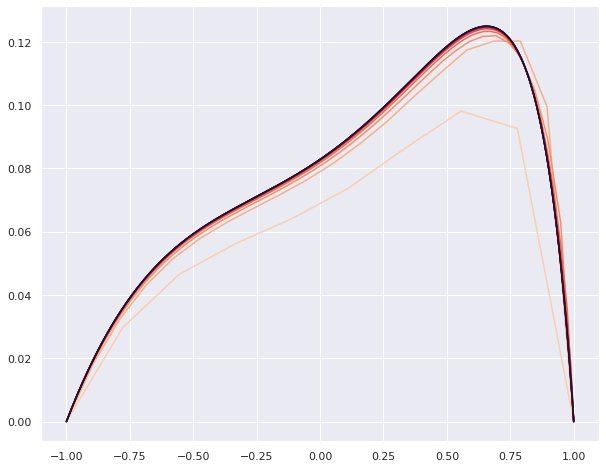

In [10]:
method.plot_solution()

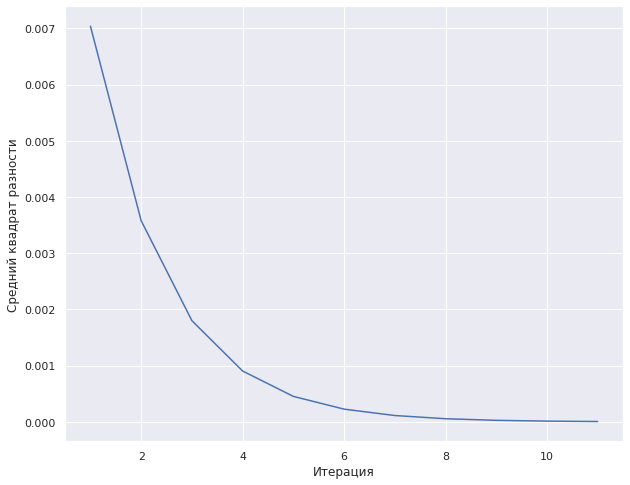

In [11]:
method.plot_error()